# Imports

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import math
import time
from PIL import Image
from scipy import fftpack
#!pip install numba
from numba import jit

# Função de DCT-2D

## Transformada Cosseno Discreta (DCT)

In [2]:
@jit(nopython=True)
def DCT_1D(data):
    N = len(data)
    X = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for k in range(N):
        if (k == 0):
            ck = math.sqrt(1.0/2.0) 
        else:
            ck = 1
        s = 0
        for n in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            s += data[n] * math.cos((a1/nn) + (a2/nn))
        X[k] = aK * ck * s
    return X

## Transformada DCT inversa (IDCT)

In [3]:
@jit(nopython=True)
def IDCT_1D(data):
    N = len(data)
    x = np.zeros(N)
    
    aK = math.sqrt(2.0/N)
    
    for n in range(N):
        s = 0
        for k in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            cK = math.sqrt(1.0/2.0) if k == 0 else 1
                
            s += cK * data[k] * math.cos((a1/nn) + (a2/nn))
            
        x[n] = aK * s
    
    return x

### Verificação de DCT & IDCT

In [4]:
array_test = np.array([4.25, 0.08993, 12.5789, -1.87, -325, 2021.2])

X_DCT_1D = DCT_1D(array_test)

X_IDCT_1D = IDCT_1D(X_DCT_1D)

print ("-> Validação das transformadas:")
if(X_IDCT_1D.all() == array_test.all()):
    print("O resultado obtido pela inversa é equivalente aos dados de entrada.")
else:
    print("Houve um erro na trasformação")
    
print ("\nDados de Entrada:")
print([ "{:0.2f}".format(x) for x in array_test ])

print ("\nAplicação da DCT_1D:")
print([ "{:0.2f}".format(x) for x in X_DCT_1D ])

print ("\nAplicação da IDCT_1D:")
print([ "{:0.2f}".format(x) for x in X_IDCT_1D ])

-> Validação das transformadas:
O resultado obtido pela inversa é equivalente aos dados de entrada.

Dados de Entrada:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']

Aplicação da DCT_1D:
['698.61', '-989.93', '1007.37', '-962.03', '775.38', '-426.05']

Aplicação da IDCT_1D:
['4.25', '0.09', '12.58', '-1.87', '-325.00', '2021.20']


## Funções auxiliares

In [5]:
def readImageByPath(path):
    imagem = Image.open(path)
    imagem = np.asarray(imagem)
    plt.imshow(imagem, cmap="gray")
    plt.title(path[6:])
    plt.show()
    return imagem

## Questão 01

### 1.1 Exibir o módulo normalizado da DCT de I, sem o nível DC, e o valor (numérico) do nível DC

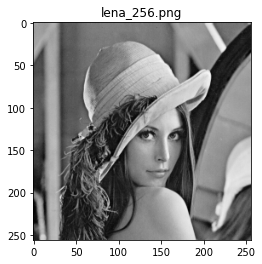

In [6]:
img_input_256 = readImageByPath ("utils/lena_256.png")

In [7]:
#img_input_256 = readImageByPath ("utils/lena.bmp")

### Aplicação de DCT 2D

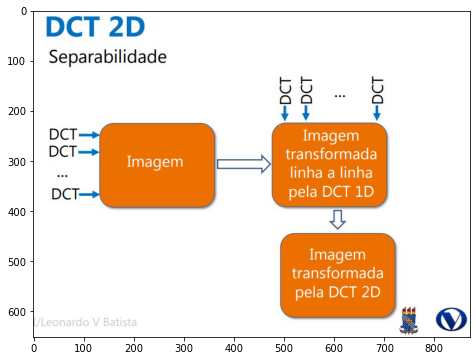

In [8]:
DCT2D_image_slide = Image.open("utils/DCT2D.jpg")
plt.figure(figsize=[60,6])
plt.imshow(DCT2D_image_slide)

In [9]:
imgDCT             = np.zeros(img_input_256.shape)
img_DCT_horizontal = np.zeros(img_input_256.shape)
img_DCT_vertical   = np.zeros(img_input_256.shape)

inicio = time.time()

#DCT nas linhas - horizontal
for i, linha in enumerate(img_input_256): 
    img_DCT_horizontal[i] = DCT_1D(linha)
    
#Transposição dos dados
img_input_vertical = img_DCT_horizontal.T

#DCT nas colunas - vertical
for i, linha in enumerate(img_input_vertical):
    img_DCT_vertical[i] = DCT_1D(linha)

fim = time.time()
print("Tempo de execução: {} segundos".format((fim - inicio)))

Tempo de execução: 1.1150703430175781 segundos


### Nível de DC

In [10]:
imgDCT = img_DCT_vertical.T
imgDCT_with_DC = imgDCT.copy()

print("Nivel DC: {}".format(imgDCT[0][0]))

Nivel DC: 31883.60937500001


### DCT com nível DC

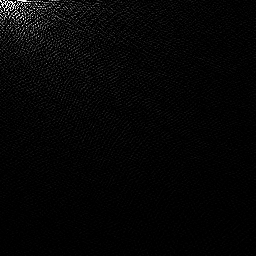

In [11]:
dct_image = Image.fromarray(imgDCT)
dct_image=dct_image.convert("P")
display(dct_image)

### DCT sem nível DC

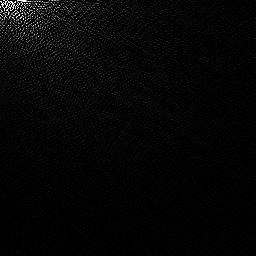

In [12]:
imgDCT[0][0] = 0
dct_image = Image.fromarray(imgDCT)
dct_image=dct_image.convert("P")
display(dct_image)

### Módulo normalizado da DCT

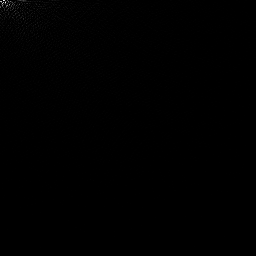

In [13]:
norm_img = imgDCT.copy()
norm_img = norm_img*(255/norm_img.max())

dct_image = Image.fromarray(norm_img)
dct_image=dct_image.convert("P")
display(dct_image)

### 1.2. Encontrar e exibir uma aproximação de I obtida preservando o coeficiente DC e os n coeficientes AC mais importantes de I, e zerando os demais. O parâmetro n é um inteiro no intervalo [0, RxC-1].

 - AC todo mundo sem o primeiro pixel
 - importante = valor mais altos em módulo sem ser o DC
 - separar os n maiores valores em módulos e zerar todos os outros
 - RC-1 -n menores em módulo serão zerados, ou seja os n maiores vão ser preservados
 - deixar o n variável (testar com 100)

In [14]:
img_selected_freq = []
samples=100 #N

In [15]:
imgDCT_original = imgDCT_with_DC.copy() 
print(imgDCT_original)

[[ 3.18836094e+04 -2.60881849e+03 -6.09081173e+02 ... -9.60908727e+00
   5.63827462e+00 -4.33025422e+00]
 [ 1.77471275e+03  1.94982908e+03 -1.62408207e+03 ...  6.59902779e+00
  -1.42185618e+00  9.81414496e+00]
 [-5.33319480e+01  7.78767089e+02 -1.49526243e+03 ...  3.10295309e+00
  -1.30754913e+01 -7.10995751e-01]
 ...
 [-2.34850900e+00 -2.77175719e-01 -1.80945068e+00 ... -1.20120105e+00
  -7.41365838e-01 -2.00899211e+00]
 [ 2.67399810e+00  8.00098579e-01  1.76698162e+00 ... -8.37296715e-01
  -2.48959322e+00 -2.97191459e+00]
 [-2.28918125e-01 -4.40566488e+00 -1.98500572e+00 ... -3.71876746e+00
   2.96303046e+00  7.22633446e+00]]


In [16]:
imgDCT_original = imgDCT_original.flatten()
size_original = (len(imgDCT_original))
print(imgDCT_original)

[ 3.18836094e+04 -2.60881849e+03 -6.09081173e+02 ... -3.71876746e+00
  2.96303046e+00  7.22633446e+00]


In [17]:
imgDCT_original_ac = imgDCT_original[1:]
size_original_ac=len(imgDCT_original_ac)
print(imgDCT_original_ac)

[-2608.81848846  -609.08117345  2472.01789449 ...    -3.71876746
     2.96303046     7.22633446]


In [18]:
imgDCT_original_tuple =  list(np.ndenumerate(imgDCT_original))
#print(imgDCT_original_tuple)

In [19]:
index_reset = np.abs(imgDCT_original_ac).argsort()[:len(imgDCT_original)-samples] #RC-N
print(index_reset)

[14334 26763 52961 ...  1801  3583  1038]


In [20]:
size_to_be_reset = len(index_reset)
print("Size original:", size_original)
print("Size AC:      ", size_original_ac)
print("Size reset:   ", size_to_be_reset) #size_ac - samples

Size original: 65536
Size AC:       65535
Size reset:    65436


In [21]:
count_zero=0
for i in range (0, size_original_ac): #Substituição dos valores que não são importantes por zero
    if(i in index_reset):
        imgDCT_original_ac[i]=0
        count_zero+=1
print(count_zero)
print(imgDCT_original_ac)

65436
[-2608.81848846  -609.08117345  2472.01789449 ...     0.
     0.             0.        ]


In [22]:
#Atualização da troca no array original para conservar o DC
imgDCT_original[1:] = imgDCT_original_ac

print(imgDCT_original)
print(len(imgDCT_original))

[31883.609375   -2608.81848846  -609.08117345 ...     0.
     0.             0.        ]
65536


In [23]:
imgDCT_original = imgDCT_original.reshape(img_input_256.shape) #Retorna o shape padrão
print(imgDCT_original)
print(len(imgDCT_original))

[[31883.609375   -2608.81848846  -609.08117345 ...     0.
      0.             0.        ]
 [ 1774.71275197  1949.82908378 -1624.0820737  ...     0.
      0.             0.        ]
 [    0.           778.76708886 -1495.26242801 ...     0.
      0.             0.        ]
 ...
 [    0.             0.             0.         ...     0.
      0.             0.        ]
 [    0.             0.             0.         ...     0.
      0.             0.        ]
 [    0.             0.             0.         ...     0.
      0.             0.        ]]
256


### Normalização

In [24]:
norm_img = imgDCT_original*(255/imgDCT_original.max())
norm_img

array([[255.        , -20.86491234,  -4.87133365, ...,   0.        ,
          0.        ,   0.        ],
       [ 14.19386828,  15.59442065, -12.98914825, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   6.22845442, -11.95886936, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [25]:
def apply_IDCT(data):
    imgIDCT = np.zeros(img_input_256.shape)

    inicio = time.time()

    for i, linha in enumerate(data): #Aplicação de IDCT na horizontal
        imgIDCT[i] = IDCT_1D(linha)

    imgIDCT= imgIDCT.T

    for i, linha in enumerate(imgIDCT): #Aplicação de IDCT na vertical
        imgIDCT[i] = IDCT_1D(linha)


    fim = time.time()
    print("IDCT Levou: {} segundos".format((fim - inicio)))

    imgIDCT  = imgIDCT.T
    data_image = imgIDCT.copy()
    return imgIDCT, data_image

In [26]:
imgIDCT, data_image_norm = apply_IDCT(norm_img)

IDCT Levou: 0.9855730533599854 segundos


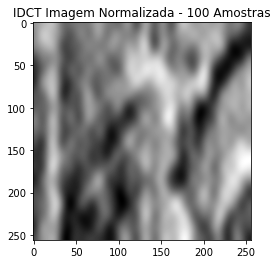

In [27]:
plt.imshow(imgIDCT, cmap="gray")
plt.title("IDCT Imagem Normalizada - {} Amostras".format(samples))
plt.savefig(f'./output/lena_normalizado_{samples}_amostras.png')
plt.show()

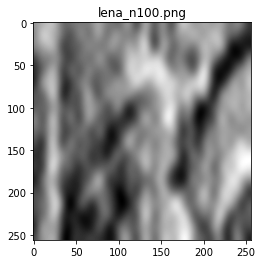

In [28]:
image_n100 = readImageByPath ("utils/lena_n100.png")

## Não normalizado

In [29]:
data_image_non_normalized = imgDCT_original.copy()
imgIDCT, data_image_non_orm = apply_IDCT(data_image_non_normalized)

IDCT Levou: 0.6911880970001221 segundos


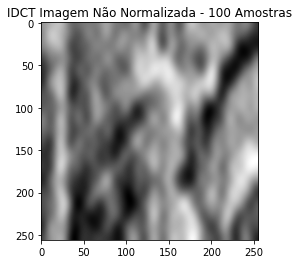

In [30]:
plt.imshow(imgIDCT, cmap="gray")
plt.savefig(f'./output/lena_nao_normalizado_{samples}_amostras.png')
plt.title("IDCT Imagem Não Normalizada - {} Amostras".format(samples))
plt.show()

## Questão 02

Desenvolva um programa para reforçar os graves, no domínio DCT, de um sinal s, em formato .wav, com N amostras. O reforço será obtido pela multiplicação do coeficiente de frequência (adimensional) k por um valor y dado por:

In [4]:
image_n100 = readImageByPath ("utils/formulaY.jpg")

NameError: name 'readImageByPath' is not defined

em que g controla o ganho (g = 0.5 é 50% de ganho máximo), fc é a frequência de corte (adimensional) e n é a ordem do filtro.

### Leitura do arquivo de áudio

In [5]:
def readAudioByPath(path):
    portion_slice = 2000
    base = 20000
    audio_rate, audio_data = wavfile.read(path)
    audio_portion = audio_data
    audio_data.shape
    return audio_rate, audio_data, audio_data.shape

In [6]:
audio_rate, audio_data, audio_data_shape = readAudioByPath('./utils/audio.wav')
print(audio_data_shape)

(125204,)


<ipython-input-5-adc00aefd203>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_rate, audio_data = wavfile.read(path)


In [7]:
def draw_audio_wave(data, title):
    plt.figure("Data", figsize=[8,8])
    plt.plot(data, linewidth=0.5,alpha=1,color="blue")
    plt.title(title)
    plt.ylabel("Amplitude")
    plt.show()

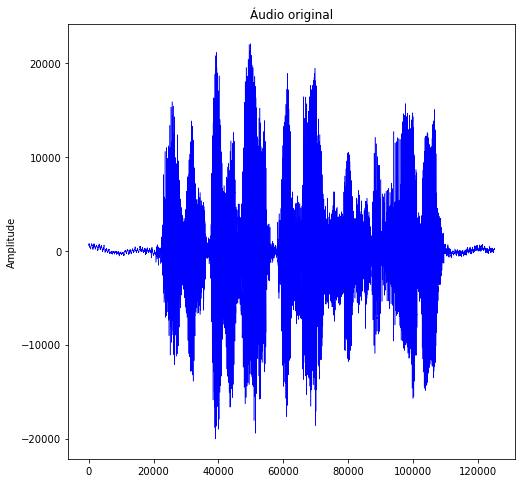

In [8]:
draw_audio_wave(audio_data, title='Áudio original')

In [9]:
@jit(nopython=True)
def DCT_1D_audio(data, g, fc, degree):
    N = len(data)
    X = np.zeros(N)
    aK = math.sqrt(2.0/N)
    for k in range(N):
        if (k == 0):
            ck = math.sqrt(1.0/2.0) 
        else:
            ck = 1
        s = 0
        for n in range(N):
            a1 = 2.0 * math.pi * k * n
            a2 = k * math.pi
            nn = 2.0 * N
            s += data[n] * math.cos((a1/nn) + (a2/nn))
        X[k] = aK * ck * s * ((g* (1/math.sqrt (1+ math.pow((k/fc),(2*degree))))) +1) 
    return X

In [10]:
g = 0.2
degree = 6
fc = 25000

### Aplicação de DCT

In [11]:
inicio = time.time()
audio_DCT = DCT_1D_audio(audio_data, g, fc, degree)
fim = time.time()
print("DCT Levou: {:3f} minutos" .format((fim - inicio)/60.0))

DCT Levou: 6.172971 minutos


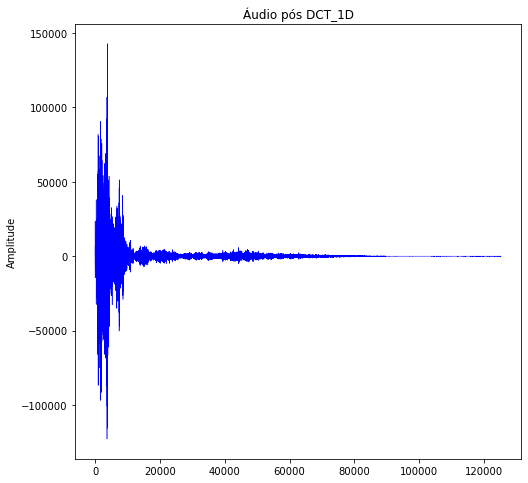

In [12]:
draw_audio_wave(audio_DCT, title='Áudio pós DCT_1D')

In [13]:
print("Nivel DC: {}".format(audio_DCT[0]))

Nivel DC: 6729.8385457757595


### Aplicação da IDCT_1D

In [14]:
inicio = time.time()
audio_IDCT = IDCT_1D(audio_DCT)
fim = time.time()
print("IDCT Levou: {:3f} minutos" .format((fim - inicio)/60))

IDCT Levou: 5.774918 minutos


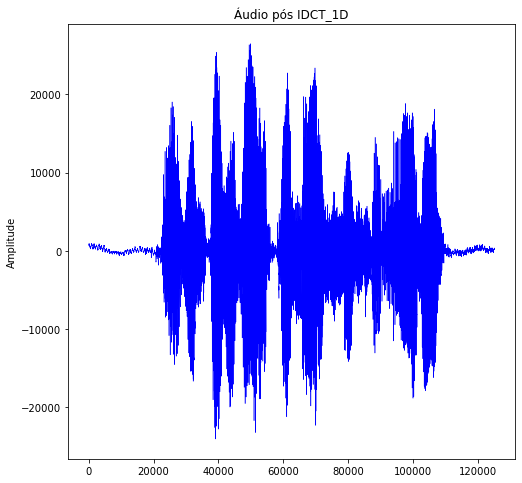

In [15]:
draw_audio_wave(audio_IDCT, title='Áudio pós IDCT_1D')

In [16]:
wavfile.write("./output/output_audio.wav", audio_rate, audio_IDCT.astype(np.int16))